# T5 TPU Tensorflow 

In [1]:
%tensorflow_version 2.x
!pip install transformers
!pip install sentencepiece

### Imports

We'll only be importing the components that we'll use during this tutorial: the TensorFlow model alongside the model specific tokenizer. The last two imports will manage the pre-processing of our data.

In [2]:
import tensorflow as tf
print(tf.__version__)

import os
from transformers import ( 
    T5Tokenizer,
    TFT5ForConditionalGeneration
)

2.4.1


In [3]:
learning_rate = 3e-5

model_size = "t5-base"

BATCH_SIZE_PER_REPLICA = 6

EPOCHS = 12

MAX_ARTICLE_LEN = 512

MAX_HIGHLIGHT_LEN = 150

last_epoch = 5

# Building the training system

## Strategy

We make use of TensorFlow's strategies, which handle the data distribution as well as the distributed training that happens on the devices available. In this example we'll be using a `MirroredStrategy` which can be used to train on a multiple GPUs in a distributed manner. 

In [4]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.81.77.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.81.77.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [5]:
strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


## Loading the Dataset with the strategy

Here we define a batch size for each replica. We set it to be a multiple of 8 to best leverage the systolic array as defined in the [Google TPU performance guide](https://cloud.google.com/tpu/docs/performance-guide#rule_of_thumb_pick_efficient_values_for_batch_and_feature_dimensions).

In [6]:
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
GLOBAL_BATCH_SIZE

48

### Retrieving the TFRecord dataset

The TFRecord dataset is now entirely processed and ready to be used as input by our training loop. We load it, shuffle it and batch it.

In [7]:
tokenizer = T5Tokenizer.from_pretrained(model_size)
en_de_prefix = tf.reshape(tokenizer("summarize English to German:", return_tensors="tf").input_ids, (-1,))
de_en_prefix = tf.reshape(tokenizer("summarize German to English: ", return_tensors="tf").input_ids, (-1,))
en_en_prefix = tf.reshape(tokenizer("summarize English to English: ", return_tensors="tf").input_ids, (-1,))
de_de_prefix = tf.reshape(tokenizer("summarize German to German: ", return_tensors="tf").input_ids, (-1,))
trans_en_de_prefix = tf.reshape(tokenizer("translate English to German: ", return_tensors="tf").input_ids, (-1,))
trans_de_en_prefix = tf.reshape(tokenizer("translate German to English: ", return_tensors="tf").input_ids, (-1,))

In [8]:
if en_de_prefix[-1] == 1: 
    en_de_prefix = en_de_prefix[:-1]
    de_en_prefix = de_en_prefix[:-1]
    en_en_prefix = en_en_prefix[:-1]
    de_de_prefix = de_de_prefix[:-1]


In [9]:
prefix_size = en_de_prefix.shape[0]
assert en_de_prefix.shape[0] == de_en_prefix.shape[0] == en_en_prefix.shape[0] == de_de_prefix.shape[0] == 5
prefix_size

5

In [10]:
en_de_prefix.numpy()

array([21603,  1566,    12,  2968,    10], dtype=int32)

In [11]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'theta-strata-260123'
!gcloud config set project {project_id}

Updated property [core/project].


In [12]:
import numpy as np

bucket = "gs://tpu-bucket-cnn-daily-mail"

def listdir_gcp(directory):
    list_dir = !gsutil ls -r {directory}
    return list_dir

def get_tf_record_files(directory_1, directory_2):
    file_list = []
    for item in listdir_gcp(directory_1):
        if item.split(".")[-1] == "tfrecord":
            file_list.append(str(item))
    for item in listdir_gcp(directory_2):
        if item.split(".")[-1] == "tfrecord":
            file_list.append(str(item))
    return file_list

def get_tfrecord_dataset(directory_1, directory_2):
    features = {
        'ger_x': tf.io.FixedLenFeature([MAX_ARTICLE_LEN-prefix_size], tf.int64),
        'ger_x_mask': tf.io.FixedLenFeature([MAX_ARTICLE_LEN-prefix_size], tf.int64),
        'ger_y': tf.io.FixedLenFeature([MAX_HIGHLIGHT_LEN], tf.int64),
        'ger_y_ids': tf.io.FixedLenFeature([MAX_HIGHLIGHT_LEN], tf.int64),

        'en_x': tf.io.FixedLenFeature([MAX_ARTICLE_LEN-prefix_size], tf.int64),
        'en_x_mask': tf.io.FixedLenFeature([MAX_ARTICLE_LEN-prefix_size], tf.int64),
        'en_y': tf.io.FixedLenFeature([MAX_HIGHLIGHT_LEN], tf.int64),
        'en_y_ids': tf.io.FixedLenFeature([MAX_HIGHLIGHT_LEN], tf.int64),
    }

    tf_records_list = get_tf_record_files(directory_1, directory_2)
    print(tf_records_list)
    dataset = tf.data.TFRecordDataset(tf_records_list)

    # Taken from the TensorFlow models repository: https://github.com/tensorflow/models/blob/befbe0f9fe02d6bc1efb1c462689d069dae23af1/official/nlp/bert/input_pipeline.py#L24
    def decode_record(record, features):
        """Decodes a record to a TensorFlow example."""
        example = tf.io.parse_single_example(record, features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.cast(t, tf.int32)
            example[name] = t
        return example


    def select_data_from_record(record):
        i  = tf.random.uniform((1,),0,4,dtype=tf.int32)[0]
        
        if i == 0:
            return tf.concat([de_de_prefix, record['ger_x']], axis=0), tf.concat([tf.ones(prefix_size, dtype=tf.int32), record['ger_x_mask']], axis=0), record['ger_y'], record['ger_y_ids']
        elif i == 1:
            return tf.concat([en_de_prefix, record['en_x']], axis=0), tf.concat([tf.ones(prefix_size, dtype=tf.int32), record['en_x_mask']], axis=0), record['ger_y'], record['ger_y_ids']
        elif i == 2:
            return tf.concat([de_en_prefix, record['ger_x']], axis=0), tf.concat([tf.ones(prefix_size, dtype=tf.int32), record['ger_x_mask']], axis=0), record['en_y'], record['en_y_ids']
        else:
            return tf.concat([en_en_prefix, record['en_x']], axis=0), tf.concat([tf.ones(prefix_size, dtype=tf.int32), record['en_x_mask']], axis=0), record['en_y'], record['en_y_ids']

    dataset = dataset.map(lambda record: decode_record(record, features))
    dataset = dataset.map(select_data_from_record)
    dataset = dataset.shuffle(500000)
    return dataset.batch(GLOBAL_BATCH_SIZE)



train_dataset = get_tfrecord_dataset(bucket + "/data/cnn_daily_mail_train/", bucket + "/data/sueddeutsche_train/")
train_dataset.prefetch(1024)

validation_dataset = get_tfrecord_dataset(bucket + "/data/cnn_daily_mail_val/", bucket + "/data/sueddeutsche_val/")
# test_dataset = get_tfrecord_dataset(bucket + "/data/sueddeutsche_val/")


['gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-0.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-1.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-10.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-11.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-12.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-13.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-14.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-15.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-2.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/cnn_daily_mail_train/cnn_daily_mail_multilingual-3.tfrecord', 'gs

In [13]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 512), (None, 512), (None, 150), (None, 150)), types: (tf.int32, tf.int32, tf.int32, tf.int32)>

There is an additional step here to distribute the dataset among the different TPU cores. We make use of a strategy method to do so.

Every item held in the dataset (which is a batched dataset) will now be split over the TPU workers. As the TPU we're using has 8 workers and our batch is of size 64, every example will be evenly split in batches of (64 / 8 =) 8 and distributed across workers.

In [14]:
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
validation_dist_dataset = strategy.experimental_distribute_dataset(validation_dataset)

## Model creation

We create a function that will instantiate a new model when called.

In [15]:
def model_fn(filename=None, epoch=None):
    model = TFT5ForConditionalGeneration.from_pretrained(model_size, output_attentions=True)
    if filename is None: 
        return model 
    else:
        ckpt_file = os.path.join(bucket, "{}/{}-{}.ckpt".format(filename, filename, epoch))
        model.load_weights(ckpt_file) 
        print("Loaded model: ", ckpt_file)
        return model

## Hyperparameters initialization

While in the strategy's scope, we define a sparse categorical crossentropy loss. We define a method `compute_loss` which will be called to compute the loss between the model's prediction and the expected result (or label).

In order to measure the accuracy during training and evaluation, we define two metrics which are both sparse categorical accuracy.

Finally, we initialize a model and create an optimizer object using the Adam optimizer.


In [16]:
with strategy.scope():
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits=True)

    def compute_loss(labels, predictions):
        per_example_loss = loss_object(labels, predictions)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

    test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
    train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy('training_accuracy')
    
    model = model_fn("t5_sum", last_epoch)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Loaded model:  gs://tpu-bucket-cnn-daily-mail/t5_sum/t5_sum-5.ckpt


## Steps

We create two functions that will be called during the training and test steps. 

In [17]:
with strategy.scope():
    def train_step(inputs):
        input_ids, input_mask, y, y_ids = inputs

        with tf.GradientTape() as tape:
            logits = model(input_ids, attention_mask=input_mask, decoder_input_ids=y_ids, training=True)[0]             
            loss = compute_loss(y, logits)

        gradients = tape.gradient(loss, model.trainable_variables)

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss_metric.update_state(loss)
        train_accuracy_metric.update_state(y, logits)

    def test_step(inputs):
        input_ids, input_mask, y, y_ids = inputs

        logits = model(input_ids, attention_mask=input_mask, decoder_input_ids=y_ids, training=False)[0]  
        t_loss = compute_loss(y, logits)

        test_loss_metric.update_state(t_loss)
        test_accuracy_metric.update_state(y, logits)

## Training & Evaluation

Finally, using all the previously defined attributes, we create two traced tf.function which will execute the training and test steps in a distributed manner. There is no need for them to return anything as the metrics will directly be updated in the steps described beforehand.

We loop over the number of epochs, training the model and evaluating it at the end of each epoch.

In [18]:
from tqdm.notebook import tqdm

training_loss_list = []

validation_loss_list = []

def save_checkpoint(filename, epoch):
    ckpt_file = os.path.join(bucket, "{}/{}-{}.ckpt".format(filename, filename, epoch))
    model.save_weights(ckpt_file) 

with strategy.scope():
    @tf.function
    def distributed_train_step(dataset):
        strategy.run(train_step, args=(dataset,))
 

    @tf.function
    def distributed_test_step(dataset):
        strategy.run(test_step, args=(dataset,))


    global_step = 0
    for epoch in range(last_epoch + 1, EPOCHS):
        total_loss = 0.0
        training_steps = 10
        epoch_step = 0
        print_every = 1000

        ### Training loop ###
        for tensor in tqdm(train_dist_dataset, desc="Training"):
            distributed_train_step(tensor)  

            train_loss = train_loss_metric.result().numpy().astype(float)
            training_loss_list.append(train_loss)
            train_accuracy = train_accuracy_metric.result().numpy()

            global_step += 1
            epoch_step += 1

            if epoch_step % print_every == 0:
                print(f"Training step {epoch_step} Accuracy: {train_accuracy}, Training loss: {train_loss}")


        ### Test loop ###
        for tensor in tqdm(validation_dist_dataset, desc="Evaluating"):
            distributed_test_step(tensor)
            
        
        ### Output results ###
        test_accuracy = test_accuracy_metric.result().numpy()
        test_loss = test_loss_metric.result().numpy()
        validation_loss_list.append(test_loss)
        print(f'Epoch: [{epoch}] Validation loss = {test_loss}')

        ### Reset metrics ###
        test_loss_metric.reset_states()
        train_accuracy_metric.reset_states()
        train_loss_metric.reset_states()
        test_accuracy_metric.reset_states()
        epoch_step = 0

        ### savecheckpoint ###
        save_checkpoint("t5_sum", epoch)

        


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training step 1000 Accuracy: 0.8483258485794067, Training loss: 13.472530364990234
Training step 2000 Accuracy: 0.8484023213386536, Training loss: 13.470149993896484
Training step 3000 Accuracy: 0.8488113880157471, Training loss: 13.429494857788086
Training step 4000 Accuracy: 0.8489645719528198, Training loss: 13.409287452697754
Training step 5000 Accuracy: 0.8489527702331543, Training loss: 13.408506393432617
Training step 6000 Accuracy: 0.8489079475402832, Training loss: 13.41225528717041
Training step 7000 Accuracy: 0.8489387035369873, Training loss: 13.410696029663086
Training step 8000 Accuracy: 0.848971962928772, Training loss: 13.406347274780273
Training step 9000 Accuracy: 0.8489662408828735, Training loss: 13.403861045837402
Training step 10000 Accuracy: 0.8490017652511597, Training loss: 13.398263931274414




Epoch: [6] Validation loss = 13.82203483581543


Training step 1000 Accuracy: 0.8494951128959656, Training loss: 13.343143463134766
Training step 2000 Accuracy: 0.8498667478561401, Training loss: 13.300565719604492
Training step 3000 Accuracy: 0.8499174118041992, Training loss: 13.288127899169922
Training step 4000 Accuracy: 0.8498465418815613, Training loss: 13.292803764343262
Training step 5000 Accuracy: 0.8500901460647583, Training loss: 13.271281242370605
Training step 6000 Accuracy: 0.8500837683677673, Training loss: 13.272871017456055
Training step 7000 Accuracy: 0.8500819802284241, Training loss: 13.272950172424316
Training step 8000 Accuracy: 0.8500590920448303, Training loss: 13.274392127990723
Training step 9000 Accuracy: 0.8500239849090576, Training loss: 13.277287483215332
Training step 10000 Accuracy: 0.850121021270752, Training loss: 13.267507553100586




Epoch: [7] Validation loss = 13.720223426818848


Training step 1000 Accuracy: 0.850775957107544, Training loss: 13.188495635986328
Training step 2000 Accuracy: 0.8507879376411438, Training loss: 13.180961608886719
Training step 3000 Accuracy: 0.8508852124214172, Training loss: 13.172224044799805
Training step 4000 Accuracy: 0.8508022427558899, Training loss: 13.174820899963379
Training step 5000 Accuracy: 0.8509569764137268, Training loss: 13.162593841552734
Training step 6000 Accuracy: 0.8510783314704895, Training loss: 13.150087356567383
Training step 7000 Accuracy: 0.8510298132896423, Training loss: 13.154943466186523
Training step 8000 Accuracy: 0.8510504961013794, Training loss: 13.152450561523438
Training step 9000 Accuracy: 0.8511843681335449, Training loss: 13.14087200164795
Training step 10000 Accuracy: 0.8512129783630371, Training loss: 13.137046813964844




Epoch: [8] Validation loss = 13.657326698303223


Training step 1000 Accuracy: 0.8518056869506836, Training loss: 13.057785034179688
Training step 2000 Accuracy: 0.8520054221153259, Training loss: 13.038091659545898
Training step 3000 Accuracy: 0.8521390557289124, Training loss: 13.028647422790527
Training step 4000 Accuracy: 0.8522599339485168, Training loss: 13.015998840332031
Training step 5000 Accuracy: 0.8522441983222961, Training loss: 13.019524574279785
Training step 6000 Accuracy: 0.8522849082946777, Training loss: 13.016058921813965
Training step 7000 Accuracy: 0.8523004055023193, Training loss: 13.014430046081543
Training step 8000 Accuracy: 0.852194607257843, Training loss: 13.023313522338867
Training step 9000 Accuracy: 0.8522165417671204, Training loss: 13.020615577697754
Training step 10000 Accuracy: 0.8522316217422485, Training loss: 13.020718574523926




Epoch: [9] Validation loss = 13.566529273986816


Training step 1000 Accuracy: 0.8522956967353821, Training loss: 12.996055603027344
Training step 2000 Accuracy: 0.8525835275650024, Training loss: 12.96228313446045
Training step 3000 Accuracy: 0.8524386882781982, Training loss: 12.976476669311523
Training step 4000 Accuracy: 0.8526418209075928, Training loss: 12.953798294067383
Training step 5000 Accuracy: 0.8527758717536926, Training loss: 12.94311237335205
Training step 6000 Accuracy: 0.8527893424034119, Training loss: 12.942115783691406
Training step 7000 Accuracy: 0.852859616279602, Training loss: 12.935508728027344
Training step 8000 Accuracy: 0.8529583811759949, Training loss: 12.927481651306152
Training step 9000 Accuracy: 0.85304194688797, Training loss: 12.919842720031738
Training step 10000 Accuracy: 0.8529479503631592, Training loss: 12.92806625366211




Epoch: [10] Validation loss = 13.528355598449707


Training step 1000 Accuracy: 0.8529602885246277, Training loss: 12.90665054321289
Training step 2000 Accuracy: 0.8533581495285034, Training loss: 12.875948905944824
Training step 3000 Accuracy: 0.8534469604492188, Training loss: 12.870112419128418
Training step 4000 Accuracy: 0.853558361530304, Training loss: 12.859880447387695
Training step 5000 Accuracy: 0.8535585403442383, Training loss: 12.859026908874512
Training step 6000 Accuracy: 0.8535636067390442, Training loss: 12.859150886535645
Training step 7000 Accuracy: 0.8535833358764648, Training loss: 12.8587007522583
Training step 8000 Accuracy: 0.8535792231559753, Training loss: 12.857369422912598
Training step 9000 Accuracy: 0.8536231517791748, Training loss: 12.852917671203613
Training step 10000 Accuracy: 0.8535869121551514, Training loss: 12.856295585632324




Epoch: [11] Validation loss = 13.49889850616455


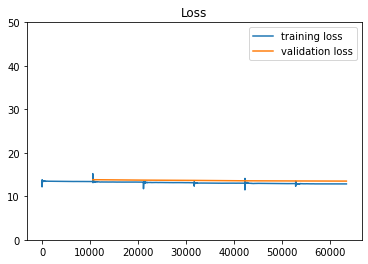

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Loss")
plt.plot(training_loss_list, label = "training loss")
plt.plot(np.arange(int(len(training_loss_list)/len(validation_loss_list)), len(training_loss_list)+1, int(len(training_loss_list)/len(validation_loss_list))), validation_loss_list, label = "validation loss")
plt.ylim(0,50)
plt.legend()
plt.show()